# Data Mining Lab 3 Pipeline Assignment

**Medium articles** are used to disseminate knowledge and are written on a wide range of technical and non-technical topics. Users subscribe to different reading lists where reading lists represent either domains or certain topics. This naturally gives rise to a network structure where articles may belong to the same reading lists and hence are related to each other. Each article belongs to a certain topic. Automatically assigning articles to topics is very valuable for search applications. **The goal of this task is to classify articles by predicting their topics.**

A dataset of medium articles along with subscription lists and topic tags is provided. The task is to classify articles into tags (i.e., topics), leveraging the network structure arising from relations using the subscription lists. Specifically, two nodes are connected if they share at least one list.

**For this task you may only use the following libraries**: `numpy`, `pandas`, `matplotlib`, `networkx`, `gensim`.


In [1]:
from collections import defaultdict
from itertools import combinations
from pathlib import Path

import networkx as nx
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from gensim.models import Word2Vec

## Data loading

The data is provided in three files which can be found in the `data` directory:

- `articles.csv`: Contains the articles along with the subscription lists and some metadata.
- `test_data.csv`: Contains a subset of nodes (articles) along with their labels (topics) used for testing.
- `train_data.csv`: Contains the remaining nodes (articles) along with their labels (topics).

**Important**: There is no specific training data requried for this assignment, since the node embeddings (task 3) are trained on the entire graph. The nodes in `train_data.csv` must be used for the kNN classifier, i.e., the computed nearest neighbors for a test node may only be nodes from this file.

Let's use `pandas` to read these files:


In [2]:
resources_path = Path("resources")

articles = pd.read_csv(resources_path / "articles.csv")
articles["node_id"] = articles.index
articles["lists"] = articles["lists"].str.split("; ")
test_data = pd.read_csv(resources_path / "test_data.csv")
train_data = pd.read_csv(resources_path / "train_data.csv")

Note that we have assigned node IDs based on where each article is located in the file.

We can now inspect the individual data frames:


In [3]:
articles.head(2)

,article,title,subtitle,author,date,lists,node_id
0,https://medium.com/@maniakacademy/code-demo-sh...,Code/Demo Share: Palo Alto Firewall Network In...,IP is broken as a unit of Control! IDENTITY as...,Sebastian Maniak,2022-08-17,[https://medium.com/@zemmali1990/list/aws-49f6...,0
1,https://medium.com/towards-artificial-intellig...,Clustering using Social Graph Network,A Social Graph Network can be formed when ther...,Naveed Ahmed Janvekar,2022-01-29,[https://medium.com/@TomaszCieplak/list/graph-...,1


In [4]:
test_data.head(2)

,node_id,label
0,2291,artificial-intelligence
1,7292,artificial-intelligence


Next, let's create our graph. We'll create one node for each article and insert an edge between two articles if they share at least one subscription list:


In [5]:
medium_graph = nx.Graph()
medium_graph.add_nodes_from(articles["node_id"].to_list())

list_to_nodes = defaultdict(set)
for _, row in articles[["node_id", "lists"]].iterrows():
    for l in row["lists"]:
        list_to_nodes[l].add(row["node_id"])

for node_ids in list_to_nodes.values():
    medium_graph.add_edges_from(combinations(node_ids, 2))

## Tasks

1. Familiarization: Analyze the graph. Compute and plot statistics such as the number of nodes, number of edges, number of neighbors of each node, and so on. Are there any isolated nodes (i.e., nodes that do not have a single neighbor)?
2. Compute spectral node embeddings.
3. Perform random walks on the graph to obtain a set of sequences of nodes. Use those sequences to compute node embeddings. Hint: You may use the Word2vec implementation of the gensim library for this task. By treating each node as a word, this method will give you node embeddings.
4. Implement a simple k-nearest neighbor classifier: For each node (medium article) in the test set, compute its nearest neighbors (based on the similarity of node embeddings). The classifier assigns a label (i.e., a topic) based on the topics of the nearest neighbors. Specifically, the predicted topic is simply the most common topic among the nearest neighbors. Compare both sets of node embeddings in terms of performance. Which one works better?


# Familiarization
---
Goal:
Analyze the graph. Compute and plot statistics such as the number of nodes, number of edges, number of neighbors of each node, and so on. Are there any isolated nodes (i.e., nodes that do not have a single neighbor)?

First get some numbers

In [6]:
print("Quick Graph stats")
print("=====================================")
print(f"Number of nodes               {medium_graph.number_of_nodes()}")
print(f"Number of edges               {medium_graph.number_of_edges()}")
print(f"Average edges per node        {medium_graph.number_of_edges() / medium_graph.number_of_nodes():.4f}")
print(f"Nodes with no edges           {sum(1 for node in medium_graph.nodes if medium_graph.degree(node) == 0)}")
print(f"Nodes with 1 edge             {sum(1 for node in medium_graph.nodes if medium_graph.degree(node) == 1)}")
print(f"Nodes with less then 5 edges  {sum(1 for node in medium_graph.nodes if medium_graph.degree(node) < 5)}")
print(f"Most connected node           {np.max([medium_graph.degree(node) for node in medium_graph.nodes])}")
print(f"Connected components          {len(list(nx.connected_components(medium_graph)))}")



Quick Graph stats
Number of nodes               27718
Number of edges               2014162
Average edges per node        72.6662
Nodes with no edges           347
Nodes with 1 edge             585
Nodes with less then 5 edges  2386
Most connected node           2452
Connected components          760


Get some per node stats

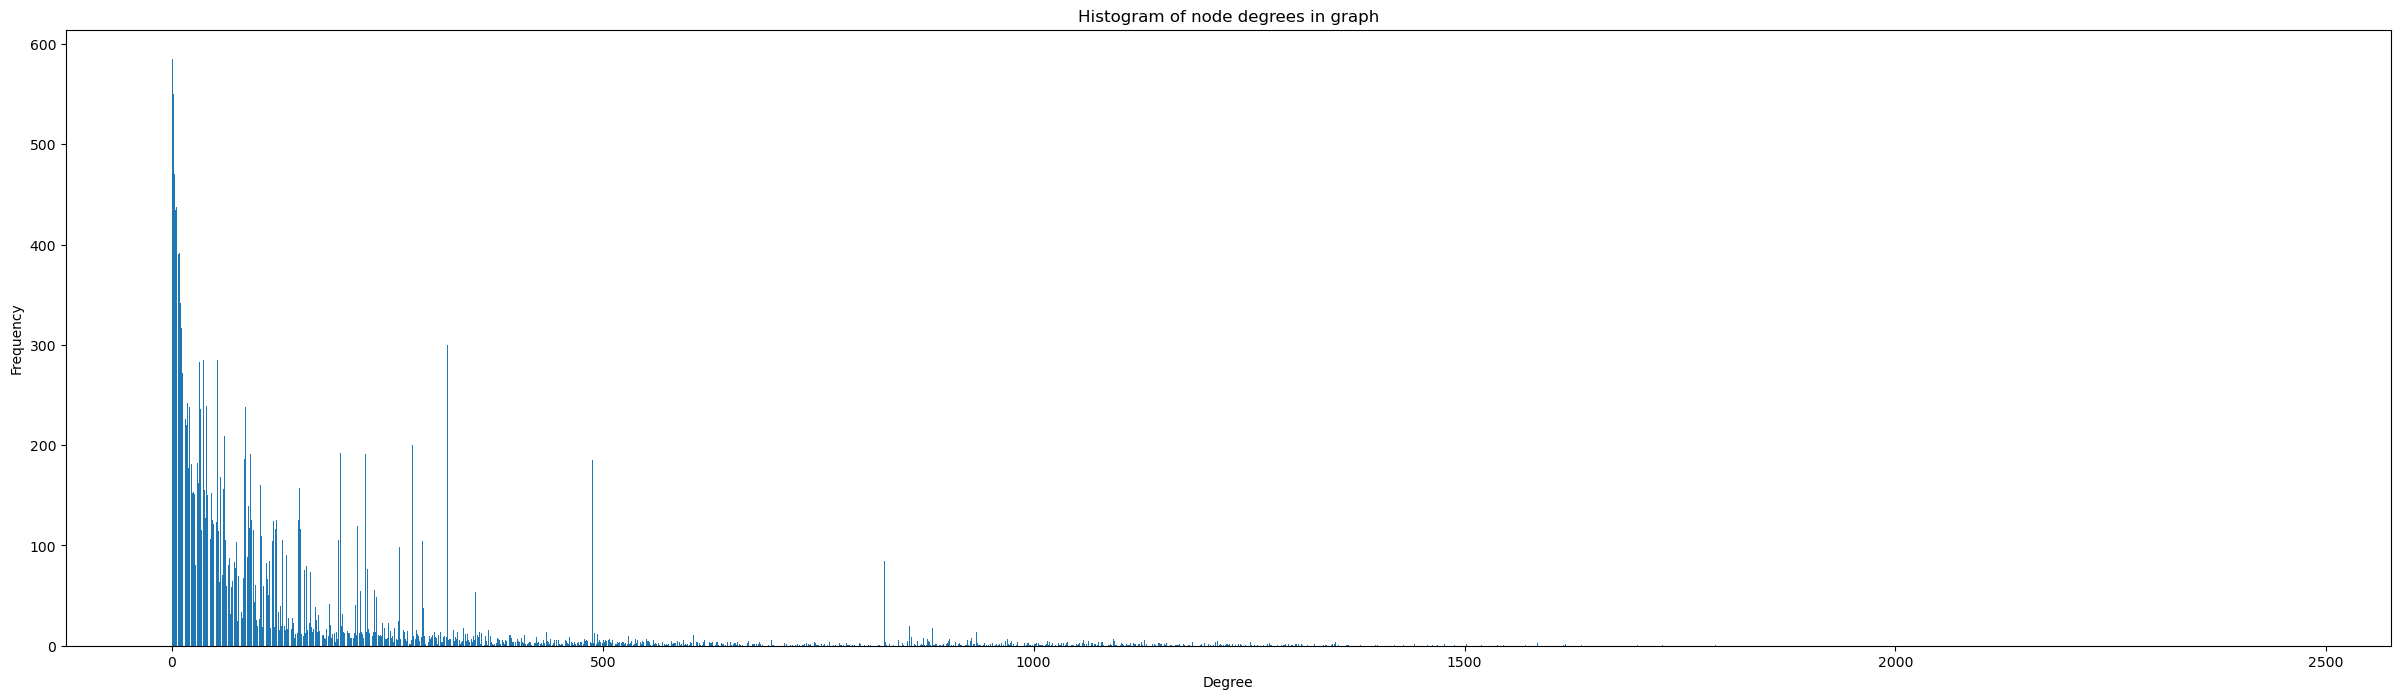

In [7]:


def count_each(counts, rounding=0):
  buckets = {}
  for value in counts:
    rounded = round(value, rounding)
    if rounded not in buckets:
      buckets[rounded] = 1
    else:
      buckets[rounded] += 1
  return buckets

degree_counts = count_each([degree for node, degree in medium_graph.degree()])

x, y = zip(*sorted(degree_counts.items()))     
plt.figure(figsize=(30, 8))
plt.bar(x, y)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title("Histogram of node degrees in graph")
plt.show()

Pareto distrobution

In [8]:

import sys
sys.setrecursionlimit(1000000)

explored = 0

def get_max_path_len(graph, node, path_length_dict, visited):
  global explored
  explored += 1
  print(f"explored {explored} nodes")


  if node in path_length_dict:
    return path_length_dict[node]
  
  max_path = 0
  for neighbor in graph.neighbors(node):
    if neighbor not in path_length_dict:
      path_length_dict[node] = max_path
      path_length_dict[neighbor] = get_max_path_len(graph, neighbor, path_length_dict, visited)
    max_path = max(max_path, 1 + path_length_dict[neighbor])

  path_length_dict[node] = max_path
  return max_path

path_lengths = []
path_length_dict = {}
print(f"Finding the longest path for {medium_graph.number_of_nodes()} nodes")
for i, node in enumerate(medium_graph.nodes()):
  if node not in path_length_dict:
    path_length_dict[node] = get_max_path_len(medium_graph, node, path_length_dict, set())
  
  path_length = path_length_dict[node]
  path_lengths.append(path_length)
  
  # print(f"{i}: {path_length}")
  

Finding the longest path for 27718 nodes
explored 1 nodes
explored 2 nodes
explored 3 nodes
explored 4 nodes
explored 5 nodes
explored 6 nodes
explored 7 nodes
explored 8 nodes
explored 9 nodes
explored 10 nodes
explored 11 nodes
explored 12 nodes
explored 13 nodes
explored 14 nodes
explored 15 nodes
explored 16 nodes
explored 17 nodes
explored 18 nodes
explored 19 nodes
explored 20 nodes
explored 21 nodes
explored 22 nodes
explored 23 nodes
explored 24 nodes
explored 25 nodes
explored 26 nodes
explored 27 nodes
explored 28 nodes
explored 29 nodes
explored 30 nodes
explored 31 nodes
explored 32 nodes
explored 33 nodes
explored 34 nodes
explored 35 nodes
explored 36 nodes
explored 37 nodes
explored 38 nodes
explored 39 nodes
explored 40 nodes
explored 41 nodes
explored 42 nodes
explored 43 nodes
explored 44 nodes
explored 45 nodes
explored 46 nodes
explored 47 nodes
explored 48 nodes
explored 49 nodes
explored 50 nodes
explored 51 nodes
explored 52 nodes
explored 53 nodes
explored 54 no

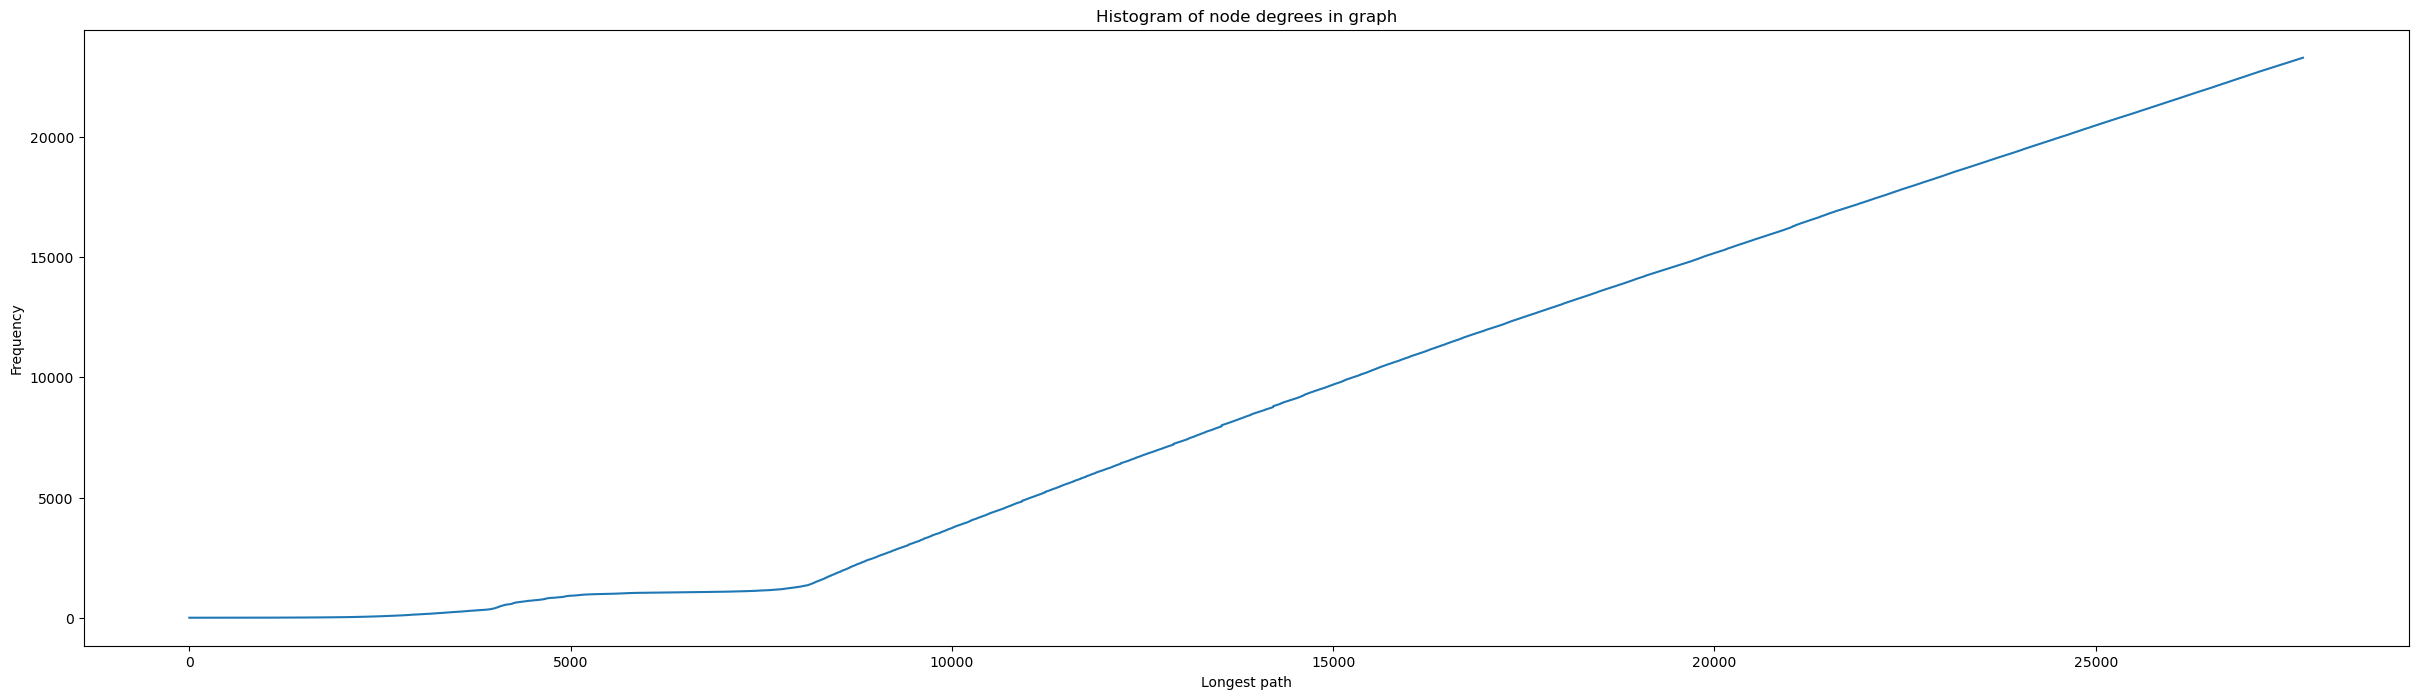

In [9]:
path_lengths_sorted = sorted(path_lengths)

plt.figure(figsize=(30, 8))
plt.plot(path_lengths_sorted) 
plt.xlabel('Longest path')
plt.ylabel('Frequency')
plt.title("Histogram of node degrees in graph")
plt.show()

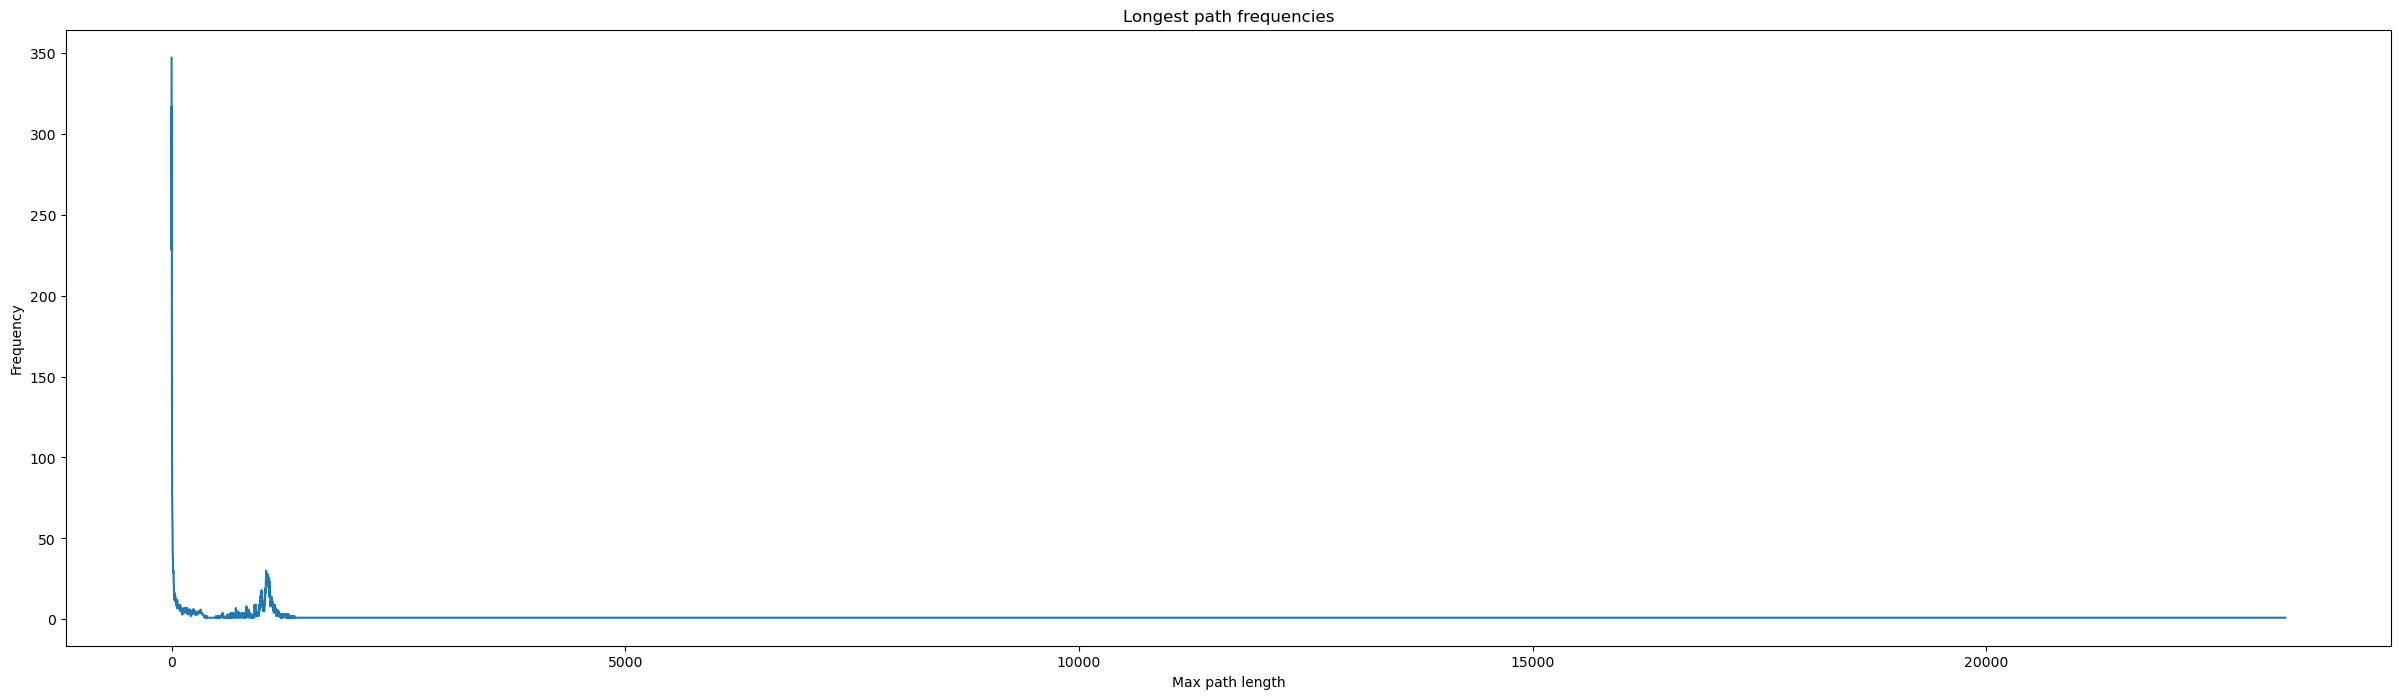

In [10]:

path_counts = count_each(path_lengths)

path_length, path_freq = zip(*sorted(path_counts.items()))   

path_length = np.array(path_length)
path_freq = np.array(path_freq)


plt.figure(figsize=(30, 8))
plt.plot(path_length, path_freq) 
plt.xlabel('Max path length')
plt.ylabel('Frequency')
plt.title("Longest path frequencies")
plt.show()


To many 1's

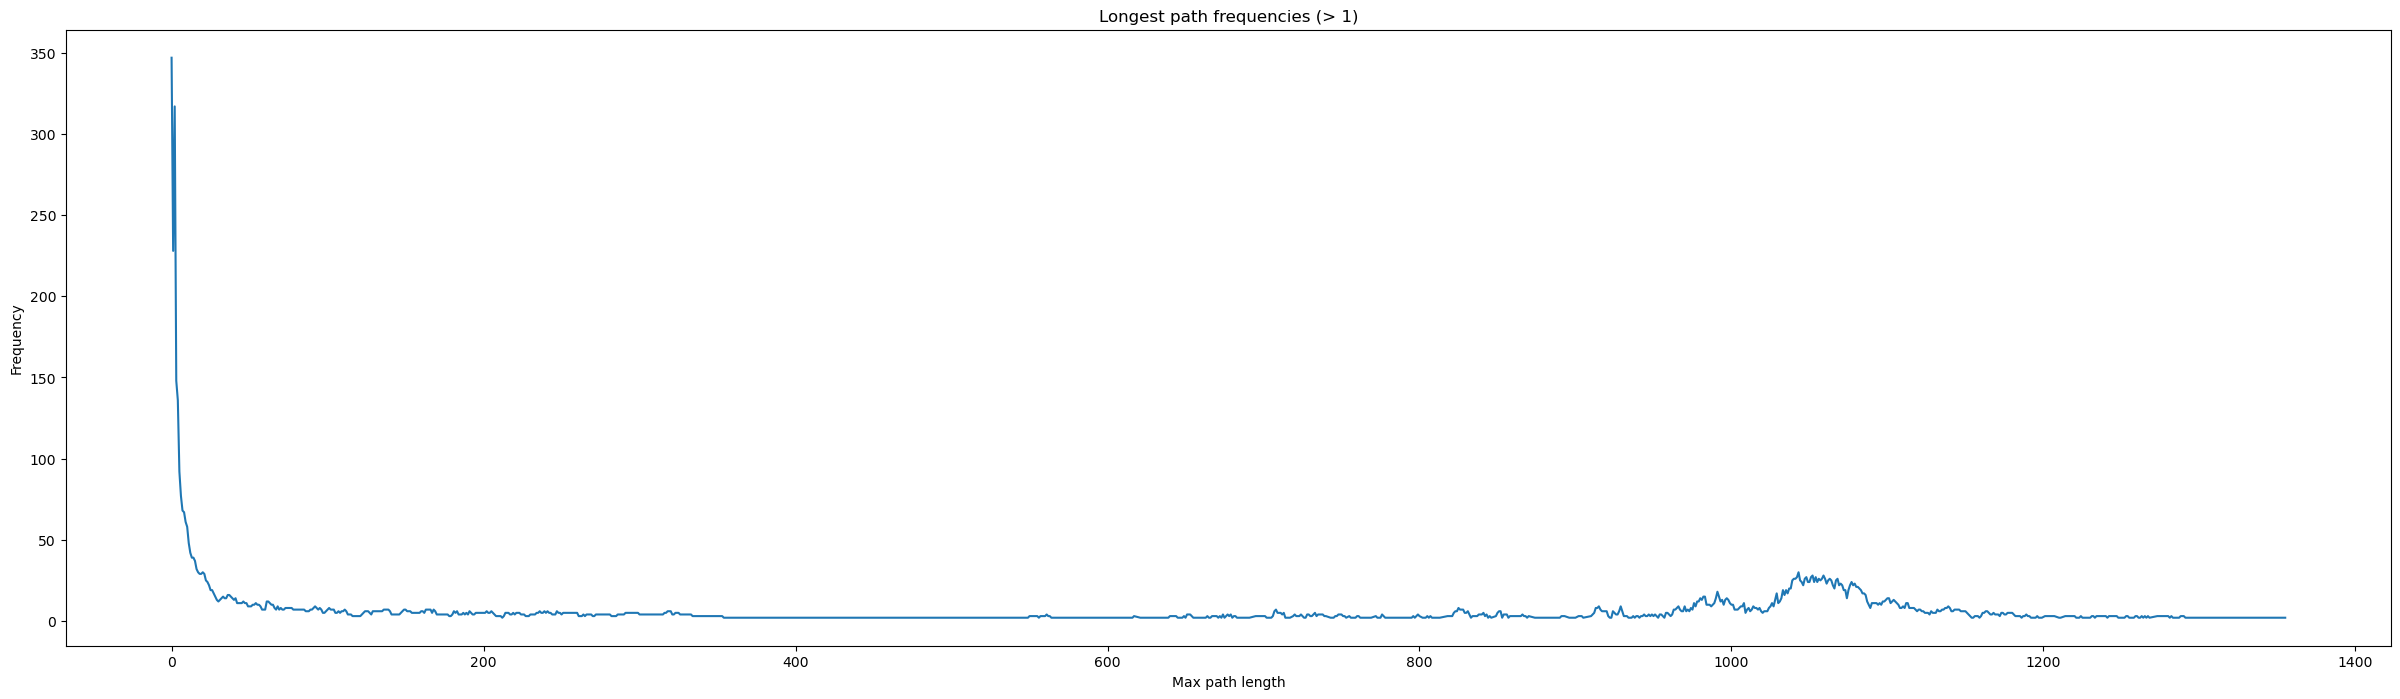

: 

In [11]:
path_length, path_freq = path_length[path_freq > 1], path_freq[path_freq > 1]
plt.figure(figsize=(30, 8))
plt.plot(path_length, path_freq) 
plt.xlabel('Max path length')
plt.ylabel('Frequency')
plt.title("Longest path frequencies (> 1)")
plt.show()


# Spectral embeddings
---
Goal: Compute spectral node embeddings.

In [12]:
def compute_spectral_embeddings(graph: nx.Graph, dim: int) -> np.ndarray:
  
  adjacency_matrix = nx.to_numpy_array(graph, nodelist=sorted(graph.nodes))
  print("Constructed adjacency matrix")
  assert (adjacency_matrix == adjacency_matrix.T).all()
  
  weight_matrix = np.diag(adjacency_matrix.sum(axis=1))
  print("Constructed weight_matrix matrix")

  laplacian = weight_matrix - adjacency_matrix
  print("Computed laplacian")

  eigenvalues, eigenvectors = np.linalg.eigh(laplacian)
  print("Computed eigenvalues and eigenvectors")

  sorted_eigenvectors = eigenvectors[np.argsort(eigenvalues)]
  print("Sorted eigenvectors")

  if dim == -1:
    reduced_eigenvectors = sorted_eigenvectors
  else:
    reduced_eigenvectors = sorted_eigenvectors[:,:dim]
  
  return reduced_eigenvectors



spectral_embeddings = compute_spectral_embeddings(medium_graph, -1)


Constructed adjacency matrix
Constructed weight_matrix matrix
Computed laplacian


In [ ]:
import pickle
import os

pickle_file_path = "resources/spectral_embeddings.pkl"

load_embeddings_from_pickle = True

if load_embeddings_from_pickle:
  if os.path.exists(pickle_file_path):
    with open(pickle_file_path, 'rb') as f:
      spectral_embeddings = pickle.load(f)
    print("Spectral embeddings loaded from pickle.")
  else:
    print("Pickle file does not exist.")
else:
  spectral_embeddings = compute_spectral_embeddings(medium_graph, -1)
  with open(pickle_file_path, 'wb') as f:
    pickle.dump(spectral_embeddings, f)
    print("Spectral embeddings saved to pickle.")


# Random walks
---
Goal: Perform random walks on the graph to obtain a set of sequences of nodes. Use those sequences to compute node embeddings. Hint: You may use the Word2vec implementation of the gensim library for this task. By treating each node as a word, this method will give you node embeddings.

In [ ]:
def random_walks(graph: nx.Graph, num_walks: int, walk_length: int) -> np.ndarray:
  result = []
  for _ in range(num_walks):
    for start_node in graph.nodes:
      walk = [start_node]
      current_node = start_node
      for _ in range(walk_length - 1):
          neighbors = list(graph.neighbors(current_node));
          current_node = np.random.choice(neighbors)
          walk.append(current_node)
      result.append(walk)
  return np.array(result)

walk_length = 10
num_walks = 10

random_node_walks = random_walks(medium_graph, walk_length,num_walks)

In [ ]:
def train_model(walks, embedding_dim):
  #TODO look into which fields to encode
  walks = [[str(node) for node in walk] for walk in walks]
  model = Word2Vec(walks, vector_size=embedding_dim, window=5, min_count=1, sg=1, workers=4)
  return model

def get_node_embeddings(model, nodes):
  node_embeddings = {}
  for node in nodes:
    node_embeddings[node] = model.wv[str(node)] 
  return node_embeddings



embedding_dim = 10

medium_model = train_model(random_node_walks, medium_nodes, embedding_dim)
word2vec_embeddings = get_node_embeddings(medium_model, medium_graph.nodes())


# Classifier
---
Goal: Implement a simple k-nearest neighbor classifier: For each node (medium article) in the test set, compute its nearest neighbors (based on the similarity of node embeddings). The classifier assigns a label (i.e., a topic) based on the topics of the nearest neighbors. Specifically, the predicted topic is simply the most common topic among the nearest neighbors. Compare both sets of node embeddings in terms of performance. Which one works better?

In [ ]:
print("Test and train data counts")
print(f"Train data length {len(train_data)}")
print(f"Test data length  {len(test_data)}")
print(f"Unique labels     {train_data['label'].unique()}")

In [ ]:
def k_nn(embeddings, test_data, train_data, k):

  node_labels = []
  for test_node, label in test_data['id']:
    test_embed = embeddings[node]

    distances = np.zeros(k)
    for i, train_node in enumerate(train_data['id']):
      train_embed = embeddings[train_node]
      distances[i] = np.linalg.norm(test_embed - test_embed)
    
    nearest_indices = np.argsort(distances)[1:-k]   # exclude the node itself
    nearest_nodes = train_data[nearest_indices]
    
    counts_per_label = np.sort(np.array(count_each(nearest_nodes['label']).items()))

    node_label = counts_per_label[0][1]
    node_labels.append(node_label)
  
  return node_labels

    

k = 10

### Using Spectral embeddings

In [ ]:
spectral_labels = k_nn(spectral_embeddings, test_data, train_data, k)

### Using Word2Vec embeddings

In [ ]:
word2vec_labels = k_nn(word2vec_embeddings, test_data, train_data, k)

In [ ]:
def evaluate(result, ground_truth):
  same = result == ground_truth
  correct = np.sum(same)
  incorrect = len(ground_truth) - correct
  accuracy = correct / len(ground_truth)
  return correct, incorrect, accuracy

